In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import os
import sys
sys.path.append('../')

In [142]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx

In [143]:
N = 30
tf = 5
delT = tf/N

In [144]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
# H1 = get_H_obs(0.75,1.5)
H1 = get_H_obs(1.2,2.3)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
# H2 = get_H_obs(0.75,1.5)
H2 = get_H_obs(1.2,2.3)
c_list.append(c2)
H_list.append(H2)

In [145]:
myModel = UnicycleModel.unicycle1('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

In [146]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [147]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [148]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [149]:
traj_solver= trajopt('unicycle',N,tf,20,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)

Is DPP?  True


In [150]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)

┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │669.082    │5.000     │32.3     │0          │-669        │0(-0.21 )│0(1.676 )│0(1.966 )│
│2     │287.432    │5.000     │115      │0          │382         │0(-1.27 )│0(11.838)│0(0.360 )│
│3     │233.189    │5.000     │160      │0          │54.2        │1(-11.14)│0(7.305 )│0(0.467 )│
│4     │129.357    │5.000     │111      │0          │104         │1(-10.85)│0(1.826 )│0(0.188 )│
│5     │141.074    │5.00

In [151]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

In [152]:
import seaborn as sns
import matplotlib.font_manager as font_manager
sns.set_style("whitegrid")
csfont = {'fontsize':20,'fontname':'Times New Roman'}
# plt.title('title',**csfont)
font = font_manager.FontProperties(family='Times New Roman',
#                                    weight='bold',
                                   style='normal', size=15)

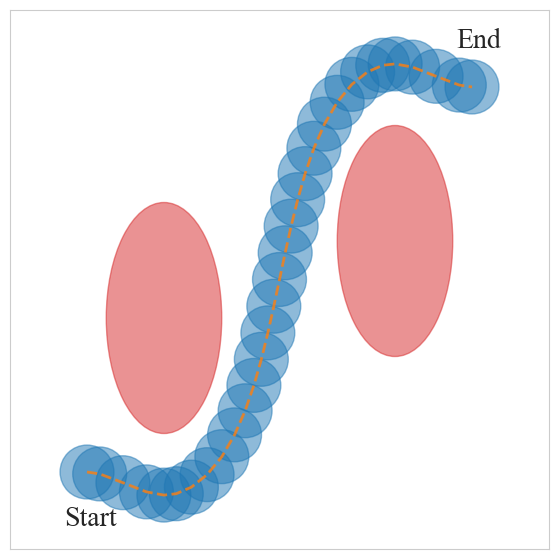

In [153]:
plt.figure(1,figsize=(7,7))
plt.rcParams["font.family"] = "Times New Roman"
plot_traj_set(xnom,unom,c_list,H_list,Q0,xi=xi,xf=xf,Qi=None,Qf=None,plt=plt,flag_label=False,fS=20)
plt.text(-0.3,-0.7,'Start',csfont)
plt.text(4.8,5.5,'End',csfont)
plt.xticks([])
plt.yticks([])
plt.savefig('../images/introduction/overestimation.pdf')
# plt.close()

In [154]:
myConst.set_obstacle(c_list,H_list)
traj_solver= trajopt('unicycle',N,tf,20,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)

Is DPP?  True
┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │542.412    │5.000     │30       │0          │-542        │0(-0.30 )│0(1.238 )│0(0.634 )│
│2     │91.044     │5.000     │46.4     │0          │451         │1(-12.13)│0(4.462 )│0(0.171 )│
│3     │79.420     │5.000     │68.1     │0          │11.6        │1(-10.85)│0(1.130 )│0(0.075 )│
│4     │74.255     │5.000     │72.5     │0          │5.16        │1(-11.79)│0(0.172 )│0(0.013 )│
│5     │74

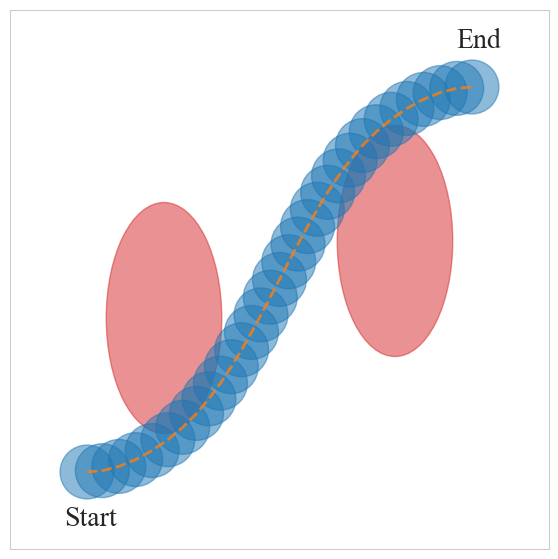

In [155]:
plt.figure(1,figsize=(7,7))
plt.rcParams["font.family"] = "Times New Roman"
plot_traj_set(xnom,unom,c_list,H_list,Q0,xi=xi,xf=xf,Qi=None,Qf=None,plt=plt,flag_label=False,fS=20)
plt.text(-0.3,-0.7,'Start',csfont)
plt.text(4.8,5.5,'End',csfont)
plt.xticks([])
plt.yticks([])
plt.savefig('../images/introduction/underestiatmion.pdf')
# plt.close()plt.xlabel()

In [156]:
myConst.set_obstacle(c_list,H_list)
traj_solver= trajopt('unicycle',N,tf,20,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf,Q0,K0)

Is DPP?  True
┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │545.750    │5.000     │31.3     │0          │-546        │0(-0.30 )│0(1.440 )│0(1.043 )│
│2     │142.831    │5.000     │70.3     │0          │403         │1(-10.38)│0(7.256 )│0(0.226 )│
│3     │112.262    │5.000     │82.4     │0          │30.6        │1(-10.28)│0(2.988 )│0(0.148 )│
│4     │90.038     │5.000     │83       │0          │22.2        │1(-12.40)│0(0.708 )│0(0.050 )│
│5     │92

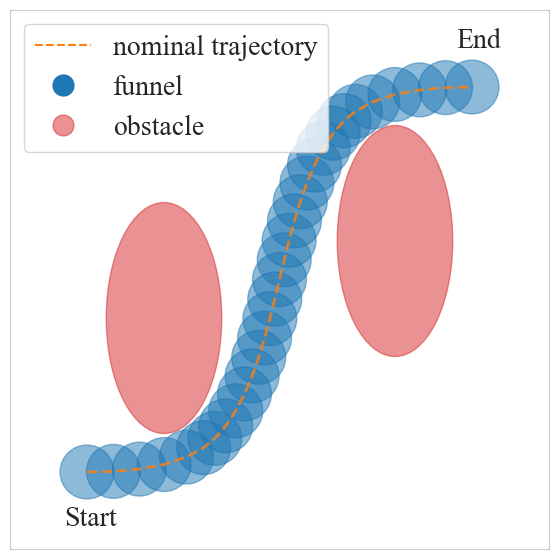

In [157]:
plt.figure(1,figsize=(7,7))
plt.rcParams["font.family"] = "Times New Roman"
plot_traj_set(xnom,unom,c_list,H_list,Q0,xi=xi,xf=xf,Qi=None,Qf=None,plt=plt,flag_label=True,fS=20)
plt.text(-0.3,-0.7,'Start',csfont)
plt.text(4.8,5.5,'End',csfont)
plt.xticks([])
plt.yticks([])
plt.savefig('../images/introduction/optimal.pdf')
# plt.close()plt.xlabel()

In [158]:
# 